<a href="https://colab.research.google.com/github/merucode/RL/blob/93-Project-Trader-Custom_enviromnet/01_Creating_a_Gym_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependency and Test

In [1]:
!git clone -b 93-Project-Trader-Custom_enviromnet https://github.com/merucode/RL.git
!cd RL && mv * ../

Cloning into 'RL'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 162 (delta 31), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (162/162), 8.66 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [5]:
!pip install -e gym-examples

Obtaining file:///content/gym-examples
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gym-examples
    Found existing installation: gym-examples 0.0.1
    Uninstalling gym-examples-0.0.1:
      Successfully uninstalled gym-examples-0.0.1
  Running setup.py develop for gym-examples


### NOTE: After inistall gym-examples, Restart runtime

# STEP. Ready Data and Test

In [6]:
!pip install -e gym-examples

Obtaining file:///content/gym-examples
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gym-examples
    Found existing installation: gym-examples 0.0.1
    Uninstalling gym-examples-0.0.1:
      Successfully uninstalled gym-examples-0.0.1
  Running setup.py develop for gym-examples


In [1]:
import pandas as pd

df1 = pd.read_csv('KRW-BTC_5m_171001_200903_upbit.csv')
df2 = pd.read_csv('KRW-BTC_5m_200904_230810_upbit.csv')

df = pd.concat([df1, df2], ignore_index=True)
df = df[df.columns[1:]]
print(df)

              open        high         low       close    volume
0        4797000.0   4800000.0   4793000.0   4800000.0  0.013444
1        4798000.0   4799000.0   4792000.0   4793000.0  0.013597
2        4795000.0   4802000.0   4795000.0   4795000.0  0.016304
3        4801000.0   4802000.0   4795000.0   4801000.0  0.017136
4        4797000.0   4799000.0   4791000.0   4799000.0  0.007615
...            ...         ...         ...         ...       ...
492907  39205000.0  39208000.0  39179000.0  39206000.0  2.508436
492908  39206000.0  39212000.0  39186000.0  39212000.0  1.350777
492909  39190000.0  39231000.0  39190000.0  39212000.0  2.929709
492910  39212000.0  39214000.0  39188000.0  39191000.0  3.407502
492911  39191000.0  39210000.0  39188000.0  39188000.0  3.884740

[492912 rows x 5 columns]


In [2]:
# Preporcessing
df_ohlc = df[df.columns[:4]]/10000
df = pd.concat([df_ohlc, df[df.columns[-1:]]], axis=1)
df = df[:1000]  # For test
print(df)

      open   high    low  close    volume
0    479.7  480.0  479.3  480.0  0.013444
1    479.8  479.9  479.2  479.3  0.013597
2    479.5  480.2  479.5  479.5  0.016304
3    480.1  480.2  479.5  480.1  0.017136
4    479.7  479.9  479.1  479.9  0.007615
..     ...    ...    ...    ...       ...
995  488.8  489.0  485.4  488.6  0.015235
996  488.6  488.8  485.1  488.4  0.016009
997  489.1  489.1  485.2  488.3  0.013057
998  485.6  489.1  485.5  488.4  0.010872
999  488.0  488.8  488.0  488.3  0.009211

[1000 rows x 5 columns]


### Check multi env

In [4]:
import time
import matplotlib.pyplot as plt
import gym
import numpy as np

envs = gym.vector.make("gym_examples:TradeWorld-v0", num_envs=2, df=df, obs_len=5)
envs.reset()
actions = np.array([10, 5])
envs.step(actions)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float64, actual type: float32
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy arr

(array([[[4.79700012e+02, 4.80000000e+02, 4.79299988e+02, 4.80000000e+02,
          1.34439999e-02],
         [4.79799988e+02, 4.79899994e+02, 4.79200012e+02, 4.79299988e+02,
          1.35970004e-02],
         [4.79500000e+02, 4.80200012e+02, 4.79500000e+02, 4.79500000e+02,
          1.63039993e-02],
         [4.80100006e+02, 4.80200012e+02, 4.79500000e+02, 4.80100006e+02,
          1.71360001e-02],
         [4.79700012e+02, 4.79899994e+02, 4.79100006e+02, 4.79899994e+02,
          7.61500001e-03]],
 
        [[4.79700012e+02, 4.80000000e+02, 4.79299988e+02, 4.80000000e+02,
          1.34439999e-02],
         [4.79799988e+02, 4.79899994e+02, 4.79200012e+02, 4.79299988e+02,
          1.35970004e-02],
         [4.79500000e+02, 4.80200012e+02, 4.79500000e+02, 4.79500000e+02,
          1.63039993e-02],
         [4.80100006e+02, 4.80200012e+02, 4.79500000e+02, 4.80100006e+02,
          1.71360001e-02],
         [4.79700012e+02, 4.79899994e+02, 4.79100006e+02, 4.79899994e+02,
          7.61

### Check Render

In [9]:
env = gym.make("gym_examples:TradeWorld-v0", df=df, obs_len=180, render_mode='rgb_array')
env.reset()

(array([[4.7970001e+02, 4.8000000e+02, 4.7929999e+02, 4.8000000e+02,
         1.3444000e-02],
        [4.7979999e+02, 4.7989999e+02, 4.7920001e+02, 4.7929999e+02,
         1.3597000e-02],
        [4.7950000e+02, 4.8020001e+02, 4.7950000e+02, 4.7950000e+02,
         1.6303999e-02],
        [4.8010001e+02, 4.8020001e+02, 4.7950000e+02, 4.8010001e+02,
         1.7136000e-02],
        [4.7970001e+02, 4.7989999e+02, 4.7910001e+02, 4.7989999e+02,
         7.6150000e-03],
        [4.8010001e+02, 4.8029999e+02, 4.8010001e+02, 4.8020001e+02,
         9.0269996e-03],
        [4.8010001e+02, 4.8029999e+02, 4.7970001e+02, 4.8029999e+02,
         7.8130001e-03],
        [4.8079999e+02, 4.8139999e+02, 4.8020001e+02, 4.8020001e+02,
         2.8278539e-01],
        [4.8020001e+02, 4.8089999e+02, 4.7979999e+02, 4.8029999e+02,
         2.1795999e-02],
        [4.8070001e+02, 4.8150000e+02, 4.8070001e+02, 4.8100000e+02,
         1.2361000e-02],
        [4.8100000e+02, 4.8100000e+02, 4.7979999e+02, 4.8039

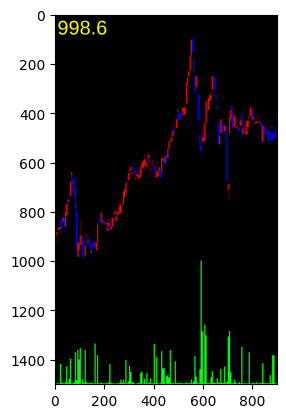

In [12]:
env.step(50)
img = env.render()
plt.figure()
plt.imshow(img)

# STEP. trade_world.py

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np

BLACK = pygame.Color(0, 0, 0)
WHITE = pygame.Color(255, 255, 255)
RED = pygame.Color(255, 0, 0)
GREEN = pygame.Color(0, 255, 0)
BLUE = pygame.Color(0, 0, 255)
YELLOW = pygame.Color(255, 255, 0)

"""
    ### Parameter
    * df : Series trade pd.DataFrame witch consist of ohlcv columns(open, high, low, close, volume)
         : It is Sorted by time ascending order
    * obs_len : What want to observate lenth from df
    * actions : The number of discrete action space
    * df_render : If you have preprocessing df and want to render with original df, use obs_df with original df

    ### Argument
    ...

    ### Method
    ...

    ### Action Space
    The action space is a `Discrete(actions)`
    | Num | Action                                                            |
    | --- | ----------------------------------------------------------------- |
    | 0   | Hold                                                              |
    | 1   | Buy coin and sell coin after 1 step                               |
    | 2   | Buy coin and sell coin after 2 step                               |
    ...
    | n   | Buy coin and sell coin after n step                               |


    ### Observation Space
    The observation space is a `Box(0, np.inf, (self.obs_len, 4), int)`. Each Num mean 1-dimension number
    | Num | Observation                                                  | Min    | Max    |
    |-----|--------------------------------------------------------------|--------|--------|
    | 0   | open                                                         | 0      | Inf    |
    | 1   | high                                                         | 0      | Inf    |
    | 2   | low                                                          | 0      | Inf    |
    | 3   | close                                                        | 0      | Inf    |
    | 4   | volume                                                       | 0      | Inf    |

    ### Reward
    Profit
"""

class TradeWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, df, df_render=None, obs_len=30, trade_action=12, render_mode=None):
        self.df = df
        self.lst_ohlcv = self.df_to_lst(self.df)  # convert DataFrame to list
        self.obs_len = obs_len
        self.time_step_limit = len(self.df) - self.obs_len - trade_action

        # Observations are ohlcv data with obeservation lenth
        self.observation_space = spaces.Box(0, np.Inf, shape=(self.obs_len, 5), dtype=float)
        # Action Space
        self.action_space = spaces.Discrete(trade_action)

        # Render
        self.df_render = df_render if df_render is not None else df
        self.lst_ohlcv_render = self.df_to_lst(self.df_render)

        self.window_size_x = 900                      # The size of the PyGame window
        self.window_size_y = 1500
        self.candle_frame_size_x = self.window_size_x # The size of the candle frame
        self.candle_frame_size_y = 900
        self.volume_frame_size_x = self.window_size_x # The volume of the candle frame
        self.volume_frame_size_y = 500
        self.score_frame_size_x = self.window_size_x  # The score of the candle frame
        self.score_frame_size_y = 100



        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None


    def _action_to_trade(self, action):
        if action == 0:
            profit = 0
        else:
            # Buy close price. After action value tiem step, sell low price(conservative profit)
            buy_price = self.lst_ohlcv[self.time_step + self.obs_len - 1][3]
            sell_price = self.lst_ohlcv[self.time_step + self.obs_len - 1 + action][2]
            # STOCK: trading_fee = -1 * buy_price*(0.015_증권사수수료)*0.01 + sell_price*(0.015_증권사수수료+0.3_세금)*0.01
            # Crypto: trading_fee = -1 * buy_price*(0.05_업비트수수료)*0.01 + sell_price*(0.05_업비트수수료)*0.01
            trading_fee = buy_price*(0.05)*0.01 + sell_price*(0.05)*0.01
            trading_fee = round(trading_fee)

            # profit = -1 * buy_close_price + sell_low_price - trade_fee
            profit = -1 * buy_price + sell_price - trading_fee
        return profit


    def _get_obs(self):
        obs_lst = self.lst_ohlcv[self.time_step:self.time_step + self.obs_len]
        return np.array(obs_lst, dtype=np.float32)

    def _get_obs_render(self):
        return self.lst_ohlcv_render[self.time_step:self.time_step + self.obs_len]

    def _get_info(self):
        return {"balance": self.balance}



    def reset(self, options=None):
        self.time_step = 0
        self.balance = 1000

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info


    def step(self, action):
        profit = self._action_to_trade(action)

        self.balance = self.balance + profit

        observation = self._get_obs()
        reward = profit
        terminated = False
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        self.time_step += 1
        return observation, reward, terminated, False, info


    ########################## RENDER ##########################
    def render(self):
        if self.render_mode == "rgb_array":
            pygame.font.init()  # For display score
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size_x, self.window_size_y))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size_x, self.window_size_y))
        canvas.fill(WHITE)

        score_frame = pygame.Surface((self.score_frame_size_x, self.score_frame_size_y))
        score_frame_rect = score_frame.get_rect()
        score_frame_rect.top = 0
        score_frame_rect.left = 0
        score_frame.fill(BLACK)
        score_font = pygame.font.SysFont('arial', 80)
        score_image = score_font.render(f'{self.balance}', True, YELLOW)
        score_frame.blit(score_image, (10, 10))
        canvas.blit(score_frame, (0, 0))
        # Candle Plot
        candle_frame = self._render_candle()
        canvas.blit(candle_frame, (0, 100))
        # Bar Plot
        volume_frame = self._render_volume()
        canvas.blit(volume_frame, (0, 1000))

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def _render_candle(self):
        candle_frame = pygame.Surface((self.candle_frame_size_x, self.candle_frame_size_y))
        candle_frame.fill(BLACK)
        candle_width = self.candle_frame_size_x // self.obs_len
        candle_line_space = candle_width // 2
        candle_line_width = 1

        observation_render = self._get_obs_render()
        scale_ohlc_lst_render = self._get_scale_ohlc_lst_render(observation_render, new_range=self.candle_frame_size_y)

        for idx in range(len(scale_ohlc_lst_render)):
            candle_x = idx * candle_width
            candle_y = self.candle_frame_size_y - max(scale_ohlc_lst_render[idx][0], scale_ohlc_lst_render[idx][3])
            candle_height = abs(scale_ohlc_lst_render[idx][0] - scale_ohlc_lst_render[idx][3])

            candle_line_y = self.candle_frame_size_y - scale_ohlc_lst_render[idx][1]
            candle_line_height = scale_ohlc_lst_render[idx][1] - scale_ohlc_lst_render[idx][2]

            if scale_ohlc_lst_render[idx][0] == scale_ohlc_lst_render[idx][3]:
                candle_height = 2
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x , candle_y, candle_width, candle_height)) # candle
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x + candle_line_space, candle_line_y, candle_line_width, candle_line_height)) # candle line
            elif scale_ohlc_lst_render[idx][0] < scale_ohlc_lst_render[idx][3]:
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x , candle_y, candle_width, candle_height))
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x + candle_line_space, candle_line_y, candle_line_width, candle_line_height)) # candle line
            else:
                pygame.draw.rect(candle_frame, BLUE,
                                 pygame.Rect(candle_x , candle_y, candle_width, candle_height))
                pygame.draw.rect(candle_frame, BLUE,
                                 pygame.Rect(candle_x + candle_line_space, candle_line_y, candle_line_width, candle_line_height)) # candle line

        return candle_frame


    def _render_volume(self):
        volume_frame = pygame.Surface((self.volume_frame_size_x, self.volume_frame_size_y))
        volume_frame.fill(BLACK)

        volume_width = self.volume_frame_size_x // self.obs_len

        observation_render = self._get_obs_render()
        scale_v_lst_render = self._get_scale_v_lst_render(observation_render, new_range=self.volume_frame_size_y)

        for idx in range(len(scale_v_lst_render)):
            volume_x = idx * volume_width
            volume_height = scale_v_lst_render[idx][0]
            volume_y = self.volume_frame_size_y - volume_height

            pygame.draw.rect(volume_frame, GREEN,
                                 pygame.Rect(volume_x , volume_y, volume_width, volume_height)) # candle
        return volume_frame


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    ########################## Util ##########################
    def df_to_lst(self, df):
        lst = []
        for i in range(len(df)):
            lst.append(df.iloc[i].tolist())
        return lst

    def _get_scale_ohlc_lst_render(self, ohlcv_lst, new_range):
        ohlc_lst = []
        for idx in range(len(ohlcv_lst)):
            ohlc_lst.append(ohlcv_lst[idx][0:4])
        ohlc_scale_lst = self._min_max_scale_lst(ohlc_lst, new_range)
        return ohlc_scale_lst

    def _get_scale_v_lst_render(self, ohlcv_lst, new_range):
        v_lst = []
        for idx in range(len(ohlcv_lst)):
            v_lst.append(ohlcv_lst[idx][-1:])
        v_scale_lst = self._min_max_scale_lst(v_lst, new_range, old_min=0)
        return v_scale_lst

    def _min_max_scale_lst(self, lst, new_range, old_min=None, old_max=None):
        old_min = min(map(min, lst)) if old_min is None else old_min # min from 2-dimension list
        old_max = max(map(max, lst)) if old_max is None else old_max # max from 2-dimension list
        new_lst = []
        new_sub_lst = []
        for sub_lst in lst:
            new_sub_lst = []
            for value in sub_lst:
                scaled_value = self._max_min_scale_value(value, old_min, old_max, new_range=new_range)
                new_sub_lst.append(scaled_value)
            new_lst.append(new_sub_lst)

        return new_lst

    def _max_min_scale_value(self,value, old_min, old_max, new_range=1):
        scaled_value = (value - old_min) / (old_max - old_min) * new_range
        scaled_value = round(scaled_value)
        return scaled_value